**Modelo ResNet18**<br>
Link do Colab: https://colab.research.google.com/drive/1FZcu3QwfZNEu-4RRWCFXclIrnBrA5Tkm#scrollTo=mo371WAisU7B

In [ ]:
import kagglehub
from PIL import Image
import io
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os
import csv
import time

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Fixar o seed para reprodutividade
set_seed()

In [ ]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [ ]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [ ]:
# Transforms padrão para ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Modelo com ResNet18 pré-treinada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carrega modelo pré-treinado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Adapta saída final para 4 classes
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.2MB/s]


Época 1/10: 100%|██████████| 320/320 [00:32<00:00,  9.86it/s]


Loss da época 1: 0.7964


Época 2/10: 100%|██████████| 320/320 [00:28<00:00, 11.31it/s]


Loss da época 2: 0.2620


Época 3/10: 100%|██████████| 320/320 [00:29<00:00, 10.88it/s]


Loss da época 3: 0.1038


Época 4/10: 100%|██████████| 320/320 [00:28<00:00, 11.37it/s]


Loss da época 4: 0.0884


Época 5/10: 100%|██████████| 320/320 [00:28<00:00, 11.32it/s]


Loss da época 5: 0.0747


Época 6/10: 100%|██████████| 320/320 [00:28<00:00, 11.12it/s]


Loss da época 6: 0.0458


Época 7/10: 100%|██████████| 320/320 [00:28<00:00, 11.30it/s]


Loss da época 7: 0.0351


Época 8/10: 100%|██████████| 320/320 [00:28<00:00, 11.11it/s]


Loss da época 8: 0.0399


Época 9/10: 100%|██████████| 320/320 [00:28<00:00, 11.16it/s]


Loss da época 9: 0.0340


Época 10/10: 100%|██████████| 320/320 [00:28<00:00, 11.12it/s]


Loss da época 10: 0.0198


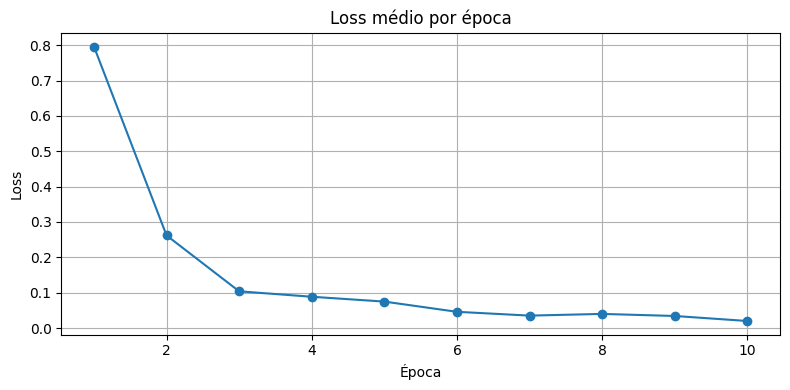

CPU times: user 4min 41s, sys: 1.54 s, total: 4min 42s
Wall time: 4min 50s


In [ ]:
%%time
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 10

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

end_time = time.time()
tempo_total = end_time - start_time

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### Carregar os dados de teste

In [ ]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Fazer predições no dataset de teste

In [ ]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


Avaliando: 100%|██████████| 80/80 [00:03<00:00, 20.02it/s]


### Calcular métricas

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

modelo = "ResNet18"

# Relatório completo por classe
print(f"\nModelo {modelo}")
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.9391
Precisão: 0.9477
Revocação: 0.9391
F1-score: 0.9407

Modelo ResNet18

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       0.76      0.98      0.86       172
 Moderate_Demented       1.00      1.00      1.00        15
      Non_Demented       0.97      0.96      0.97       634
Very_Mild_Demented       0.98      0.89      0.94       459

          accuracy                           0.94      1280
         macro avg       0.93      0.96      0.94      1280
      weighted avg       0.95      0.94      0.94      1280



### Matriz de confusão

In [ ]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                 169                  0             2                   1
Moderate_Demented               0                 15             0                   0
Non_Demented                   20                  0           608                   6
Very_Mild_Demented             33                  0            16                 410


In [ ]:
resultados = {
    "modelo": modelo,
    "epocas": num_epochs,
    "tempo_total": round(tempo_total, 2), # em segundos
    "acuracia": round(accuracy, 4),
    "precisao": round(precision, 4),
    "revocacao": round(recall, 4),
    "f1_macro": round(f1, 4)
}

In [ ]:
import re

def limpar_nome_arquivo(nome):
    """
    Substitui caracteres inválidos em nomes de arquivos por underline (_).

    Parâmetros:
    nome (str): O nome original do arquivo que pode conter caracteres inválidos.

    Retorna:
    str: Uma versão do nome do arquivo onde os caracteres inválidos (\, /, :, ", *, ?, <, >, |)
         foram substituídos por underscores (_), tornando o nome seguro para uso em sistemas de arquivos.
    """
    return re.sub(r'[\\/:"*?<>|]+', "_", nome)

nome_seguro = limpar_nome_arquivo(modelo)

In [ ]:
file_path = f"resultados_do_modelo_{nome_seguro}.csv"
campos = list(resultados.keys())

# Cria o arquivo se não existir
if not os.path.exists(file_path):
    with open(file_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writeheader()
        writer.writerow(resultados)
else:
    # Apenas adiciona nova linha
    with open(file_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writerow(resultados)